In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

foldername = '/content/drive/My Drive/trans/transformer-glucose/'
assert foldername is not None, "[!] Enter the foldername."

# add path to .py code
import sys
sys.path.append(foldername)

Mounted at /content/drive


In [ ]:
# load libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from gluformer.attention import *
from gluformer.encoder import *
from gluformer.decoder import *
from gluformer.embed import *
from gluformer.model import *
from gludata.data_loader import *
from utils.train import *
from utils.test import *

In [ ]:
# load data
PATH = foldername + '/gludata/data/'
BATCH_SIZE = 1
LEN_PRED = 12
LEN_LABEL = 60
LEN_SEQ = 180

test_data = CGMData(PATH, 'test', [LEN_SEQ, LEN_LABEL, LEN_PRED])
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)

In [ ]:
%%capture
LEN_PRED_MODEL = 12
LEN_LABEL = 60
LEN_SEQ = 180

# define model
D_MODEL = 512
D_FCN = 2048
N_HEADS = 8
R_DROP = 0.05
ACTIV = "relu"
NUM_ENC_LAYERS = 2
NUM_DEC_LAYERS = 1
DISTIL = True
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Gluformer(d_model=D_MODEL, n_heads=N_HEADS, d_fcn=D_FCN, r_drop=R_DROP, activ=ACTIV, 
                 num_enc_layers=NUM_ENC_LAYERS, num_dec_layers=NUM_DEC_LAYERS,
                 distil=DISTIL, len_pred=LEN_PRED_MODEL)
model.load_state_dict(torch.load(foldername + "/model_best.pth"))
model = model.to(DEVICE)
model.eval()

In [ ]:
UPPER = 402
LOWER = 38
SCALE_1 = 5
SCALE_2 = 2

# compute test loss
test_loss_12= []
test_loss_3 = []
test_loss_6 = []
test_loss_9 = []
test_loss_rmse_12 = []
test_loss_rmse_3 = []
test_loss_rmse_6 = []
test_loss_rmse_9 = []
for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
  pred, true = predict_batch(subj_id = subj_id, 
                              batch_x=batch_x, 
                              batch_y=batch_y, 
                              batch_x_mark=batch_x_mark, 
                              batch_y_mark=batch_y_mark, 
                              len_pred=LEN_PRED, 
                              len_pred_model=LEN_PRED_MODEL,
                              len_label=LEN_LABEL, 
                              model=model, 
                              device=DEVICE)
  pred = pred.detach().cpu().numpy(); true = true.detach().cpu().numpy()
  # transform back
  pred = (pred + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
  true = (true + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
  # compute APE: full
  ape_12 = np.mean(np.abs((pred - true)) / np.abs(true))
  rmse_12 = np.sqrt(np.mean((pred - true)**2))
  # compute APE: 15 mins (3 points)
  ape_3 = np.mean(np.abs((pred[:, :3, :] - true[:, :3, :])) / np.abs(true[:, :3, :]))
  rmse_3 = np.sqrt(np.mean((pred[:, :3, :] - true[:, :3, :])**2))
  # compute APE: 30 mins (6 points)
  ape_6 = np.mean(np.abs((pred[:, :6, :] - true[:, :6, :])) / np.abs(true[:, :6, :]))
  rmse_6 = np.sqrt(np.mean((pred[:, :6, :] - true[:, :6, :])**2))
  # compute APE: 45 mins (9 points)
  ape_9 = np.mean(np.abs((pred[:, :9, :] - true[:, :9, :])) / np.abs(true[:, :9, :]))
  rmse_9 = np.sqrt(np.mean((pred[:, :9, :] - true[:, :9, :])**2))
  test_loss_12.append(ape_12)
  test_loss_3.append(ape_3)
  test_loss_6.append(ape_6)
  test_loss_9.append(ape_9)
  test_loss_rmse_12.append(rmse_12)
  test_loss_rmse_3.append(rmse_3)
  test_loss_rmse_6.append(rmse_6)
  test_loss_rmse_9.append(rmse_9)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


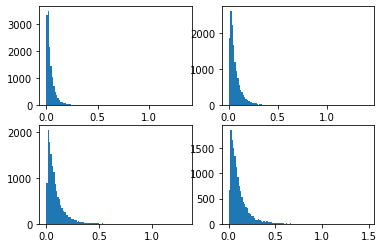

In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,0].hist(np.array(test_loss_3), 100)
axarr[0,1].hist(np.array(test_loss_6), 100)
axarr[1,0].hist(np.array(test_loss_9), 100)
axarr[1,1].hist(np.array(test_loss_12), 100)
plt.show()

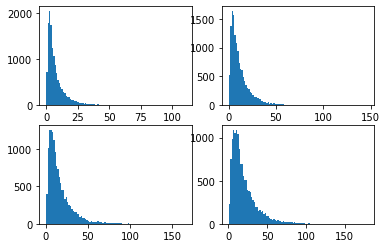

In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,0].hist(np.array(test_loss_rmse_3), 100)
axarr[0,1].hist(np.array(test_loss_rmse_6), 100)
axarr[1,0].hist(np.array(test_loss_rmse_9), 100)
axarr[1,1].hist(np.array(test_loss_rmse_12), 100)
plt.show()

In [ ]:
print("Test loss for 15 mins: {0:.7f}, for 30 mins: {1:.7f}, for 45 mins: : {2:.7f}, for 60 mins: {3:.7f}".format(
    np.median(np.array(test_loss_3)), 
    np.median(np.array(test_loss_6)),
    np.median(np.array(test_loss_9)),
    np.median(np.array(test_loss_12))))

Test loss for 15 mins: 0.0293564, for 30 mins: 0.0467292, for 45 mins: : 0.0635971, for 60 mins: 0.0782405


In [ ]:
print("Test loss for 15 mins: {0:.7f}, for 30 mins: {1:.7f}, for 45 mins: : {2:.7f}, for 60 mins: {3:.7f}".format(
    np.median(np.array(test_loss_rmse_3)), 
    np.median(np.array(test_loss_rmse_6)),
    np.median(np.array(test_loss_rmse_9)),
    np.median(np.array(test_loss_rmse_12))))

Test loss for 15 mins: 5.1577663, for 30 mins: 8.6329002, for 45 mins: : 11.8065443, for 60 mins: 14.7381554
